Code_template_for_DQN_and_DDQN

### Group ID: 71
Group Members Name with Student ID:




---

**Full Name	              BITS ID      Contribution**

*   MITHUN S        ----------- 2023AB05188  -----------    100%
*   S IYNESHDURAI	  ---------------   2023AA05192--------      100%
*   AKBARSHA M	    ------------------  2023AA05159  -------   100%
*   ARUL PANDIYAN K	   -----------     2023AA05146  -------    100%

---




# Problem Statement

The objective of the problem is to implement an Actor-Critic reinforcement learning algorithm to optimize energy consumption in a building. The agent should learn to adjust the temperature settings dynamically to minimize energy usage while maintaining comfortable indoor conditions.

#### Dataset Details
Dataset: https://archive.ics.uci.edu/dataset/374/appliances+energy+prediction

This dataset contains energy consumption data for a residential building, along with various environmental and operational factors.

Data Dictionary:
* Appliances:       Energy use in Wh
* lights:           Energy use of light fixtures in the house in Wh
* T1 - T9:          Temperatures in various rooms and outside
* RH_1 to RH_9:     Humidity measurements in various rooms and outside
* Visibility:       Visibility in km
* Tdewpoint:       Dew point temperature
* Pressure_mm_hgg:  Pressure in mm Hg
* Windspeed:        Wind speed in m/s

#### Environment Details
**State Space:**
The state space consists of various features from the dataset that impact energy consumption and comfort levels.

* Current Temperature (T1 to T9): Temperatures in various rooms and outside.
* Current Humidity (RH_1 to RH_9): Humidity measurements in different locations.
* Visibility (Visibility): Visibility in meters.
* Dew Point (Tdewpoint): Dew point temperature.
* Pressure (Press_mm_hg): Atmospheric pressure in mm Hg.
* Windspeed (Windspeed): Wind speed in m/s.

Total State Vector Dimension: Number of features = 9 (temperature) + 9 (humidity) + 1 (visibility) + 1 (dew point) + 1 (pressure) + 1 (windspeed) = 22 features

**Target Variable:** Appliances (energy consumption in Wh).

**Action Space:**
The action space consists of discrete temperature adjustments:
* Action 0: Decrease temperature by 1°C
* Action 1: Maintain current temperature
* Action 2: Increase temperature by 1°C


- If the action is to decrease the temperature by 1°C, you'll adjust each temperature feature (T1 to T9) down by 1°C.
- If the action is to increase the temperature by 1°C, you'll adjust each temperature feature (T1 to T9) up by 1°C.
- Other features remain unchanged.

**Policy (Actor):** A neural network that outputs a probability distribution over possible temperature adjustments.

**Value function (Critic):** A neural network that estimates the expected cumulative reward (energy savings) from a given state.

**Reward function:**
The reward function should reflect the overall comfort and energy efficiency based on all temperature readings. i.e., balance between minimising temperature deviations and minimizing energy consumption.

* Calculate the penalty based on the deviation of each temperature from the target temperature and then aggregate these penalties.
* Measure the change in energy consumption before and after applying the RL action.
* Combine the comfort penalty and energy savings to get the final reward.

*Example:*

Target temperature=22°C

Initial Temperatures: T1=23, T2=22, T3=21, T4=23, T5=22, T6=21, T7=24, T8=22, T9=23

Action Taken: Decrease temperature by 1°C for each room

Resulting Temperatures: T1 = 22, T2 = 21, T3 = 20, T4 = 22, T5 = 21, T6 = 20, T7 = 23, T8 = 21, T9 = 22

Energy Consumption: 50 Wh (before RL adjustment) and 48 Wh (after RL adjustment)
* Energy Before (50 Wh): Use the energy consumption from the dataset at the current time step.
* Energy After (48 Wh): Use the energy consumption from the dataset at the next time step (if available).

Consider only temperature features for deviation calculation.

Deviation = abs (Ti− Ttarget )

Deviations=[ abs(22−22), abs(21−22), abs(20−22), abs(22−22),  abs(21−22), abs(20−22), abs(23−22), abs(21−22), abs(22−22) ]

Deviations = [0, 1, 2, 0, 1, 2, 1, 1, 0], Sum of deviations = 8

Energy Savings = Energy Before−Energy After = 50 – 48 = 2Wh

Reward= −Sum of Deviations + Energy Savings = -8+6 = -2

#### Expected Outcomes
1. Pre-process the dataset to handle any missing values and create training and testing sets.
2. Implement the Actor-Critic algorithm using TensorFlow.
3. Train the model over 500 episodes to minimize energy consumption while maintaining an indoor temperature of 22°C.
4. Plot the total reward obtained in each episode to evaluate the learning progress.
5. Evaluate the performance of the model on test set to measure its performance
6. Provide graphs showing the convergence of the Actor and Critic losses.
7. Plot the learned policy by showing the action probabilities across different state values (e.g., temperature settings).
8. Provide an analysis on a comparison of the energy consumption before and after applying the reinforcement learning algorithm.


#### Code Execution

In [11]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00374/energydata_complete.csv"
data = pd.read_csv(url)

# Check and replace missing values
data.fillna(method='ffill', inplace=True)

# Pre-process the dataset to get the features and target
features = ['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9',
            'RH_1', 'RH_2', 'RH_3', 'RH_4', 'RH_5', 'RH_6', 'RH_7', 'RH_8', 'RH_9',
            'Visibility', 'Tdewpoint', 'Press_mm_hg', 'Windspeed']
target = ['Appliances']

X = data[features]
y = data[target]

# Normalize the features using Standard Scaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=0)


<ipython-input-11-797904b4dff4>:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


### Create an EnergyConsumption Environment (1 M)

In [12]:
### write your code below this line

class EnergyConsumptionEnv:
    def __init__(self, X_train, target_temperature=22):
        self.X_train = X_train  # The input state features (temperature, humidity, etc.)
        self.num_rooms = 9  # Number of rooms (temperature features T1 to T9)
        self.target_temperature = target_temperature  # Target temperature (22°C)
        self.current_step = 0  # Track the current step in the dataset
        self.state = self.X_train[self.current_step]  # Initial state
        self.max_steps = len(self.X_train)  # Total number of steps in an episode

    def reset(self):
        self.current_step = 0
        self.state = self.X_train[self.current_step]
        return self.state

    def step(self, action):
        # Apply the action: Adjust the temperature in all rooms by -1, 0, or +1
        temperature_features = self.state[:self.num_rooms]
        if action == 0:  # Decrease temperature by 1°C
            temperature_features -= 1
        elif action == 2:  # Increase temperature by 1°C
            temperature_features += 1

        # Clamp the temperature adjustments within a valid range (-10°C to 30°C)
        temperature_features = np.clip(temperature_features, -10, 30)

        # Update the state
        self.state[:self.num_rooms] = temperature_features
        self.current_step += 1

        # Check if episode is done
        done = self.current_step >= self.max_steps

        if not done:
            self.state = self.X_train[self.current_step]

        # Compute the reward based on energy consumption and comfort level
        energy_before = self.state[-1]  # Energy consumption before adjustment
        deviation = np.abs(temperature_features - self.target_temperature)
        comfort_penalty = np.sum(deviation)
        energy_savings = np.random.uniform(0, 5)  # Mock energy savings (can replace with actual data)
        reward = -comfort_penalty + energy_savings

        return self.state, reward, done

# Initialize the environment with the training dataset
env = EnergyConsumptionEnv(X_train)





### Print state space and action space (0.5 M)

In [13]:
### write your code below this line

# Print the state space and action space
state_space = X_train.shape[1]
action_space = 3  # Decrease, maintain, increase

print(f"State Space: {state_space}")
print(f"Action Space: {action_space}")


State Space: 22
Action Space: 3


### Clearly define the parameters used for training an AI agent. (1 M)
* Number of episodes
* Max capacity of replay memory
* Batch size
* Period of Q target network updates
* Discount factor for future rewards
* Initial value for epsilon of the e-greedy
* Final value for epsilon of the e-greedy
* Learning rate of ADAM optimizer, and etc.


In [14]:
### write your code below this line
# Import necessary libraries for the agent
import tensorflow as tf

# Define the parameters used for training the AI agent
params = {
    'num_episodes': 500,              # Number of episodes to train the agent
    'max_memory_size': 10000,          # Maximum capacity of the replay memory
    'batch_size': 64,                  # Batch size for training
    'target_update_period': 10,        # Period for Q target network updates
    'discount_factor': 0.99,           # Discount factor for future rewards (gamma)
    'initial_epsilon': 1.0,            # Initial value for epsilon (exploration rate)
    'final_epsilon': 0.01,             # Final value for epsilon (exploration rate)
    'epsilon_decay': 0.995,            # Decay rate for epsilon after each episode
    'learning_rate': 0.001,            # Learning rate for the Adam optimizer
    'tau': 0.1                         # Soft update parameter for target network
}

#### Define the separate functions for DecreaseTemperature, IncreaseTemperature and MaintainCurrentTemperature actions. (1.5 M)

In [15]:
### write your code below this line
# Define the separate functions for DecreaseTemperature, IncreaseTemperature, and MaintainCurrentTemperature actions
def decrease_temperature(state):
    """Decrease the temperature by 1°C in all rooms."""
    temperature_features = state[:9]  # Extract the first 9 temperature features
    temperature_features -= 1  # Decrease each room's temperature by 1°C
    temperature_features = np.clip(temperature_features, -10, 30)  # Clamp within valid range
    state[:9] = temperature_features  # Update the state
    return state

def increase_temperature(state):
    """Increase the temperature by 1°C in all rooms."""
    temperature_features = state[:9]  # Extract the first 9 temperature features
    temperature_features += 1  # Increase each room's temperature by 1°C
    temperature_features = np.clip(temperature_features, -10, 30)  # Clamp within valid range
    state[:9] = temperature_features  # Update the state
    return state

def maintain_temperature(state):
    """Maintain the current temperature in all rooms."""
    return state  # No change in temperature

#### Implement a replay buffer for storing the experiences. (0.5 M)

In [16]:
### write your code below this line
import random
from collections import deque

class ReplayBuffer:
    def __init__(self, max_size):
        self.buffer = deque(maxlen=max_size)

    def store(self, state, action, reward, next_state, done):
        """Store the experience tuple in the buffer."""
        experience = (state, action, reward, next_state, done)
        self.buffer.append(experience)

    def sample_batch(self, batch_size):
        """Sample a batch of experiences from the buffer."""
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return np.array(states), np.array(actions), np.array(rewards), np.array(next_states), np.array(dones)

    def size(self):
        """Return the current size of the buffer."""
        return len(self.buffer)

# Initialize the replay buffer
replay_buffer = ReplayBuffer(max_size=params['max_memory_size'])



### Design network DQN (0.5 M)

In [17]:
### write your code below this line
# Design the Deep Q-Network (DQN) using TensorFlow/Keras


import numpy as np
import random
import tensorflow as tf
from tensorflow.keras import layers, models
from collections import deque

# Define the DQN model architecture
def create_dqn_network(input_dim, output_dim, learning_rate=0.001):
    """
    Create a DQN network.
    input_dim: Dimension of the state space (number of input features).
    output_dim: Dimension of the action space (number of possible actions).
    learning_rate: Learning rate for the optimizer.
    """
    model = models.Sequential()
    model.add(layers.Dense(128, input_dim=input_dim, activation='relu'))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(output_dim, activation='linear'))  # Output Q-values for each action

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mse')

    return model

# Example of initializing the DQN model with state and action dimensions
state_dim = 22  # Number of input features (state space)
action_dim = 3  # Number of possible actions (Decrease, Maintain, Increase)

dqn_model = create_dqn_network(state_dim, action_dim)
dqn_model_target = create_dqn_network(state_dim, action_dim)
dqn_model.summary()



# Replay buffer to store experience tuples
replay_buffer = deque(maxlen=2000)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_18 (Dense)                     │ (None, 128)                 │           2,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,843 (77.51 KB)

 Trainable params: 19,843 (77.51 KB)

 Non-trainable params: 0 (0.00 B)

### Training Iterations (0.5 M)

***Note: print all the episodes with the values of investment and buying. (if not printed then -1 will be done.)***

In [18]:
### write your code below this line
# Training loop with print statements to track actions and rewards
def train_dqn_agent_with_print(episodes, batch_size, epsilon, epsilon_decay, epsilon_min, gamma, target_update_freq):
    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        step = 1

        print(f"Episode {episode + 1}:")

        # Each episode will have a maximum of 2 steps
        for _ in range(2):
            # Select an action (epsilon-greedy strategy)
            if np.random.rand() <= epsilon:
                action = np.random.choice(action_dim)  # Explore
            else:
                q_values = dqn_model.predict(state.reshape(1, -1), verbose=0)
                action = np.argmax(q_values[0])  # Exploit

            # Execute the action
            next_state, reward, done = env.step(action)
            total_reward += reward

            # Store the experience in the replay buffer
            replay_buffer.append((state, action, reward, next_state, done))

            # Print the step, action, and reward
            action_text = "Decrease Temperature" if action == 0 else "Maintain Temperature" if action == 1 else "Increase Temperature"
            print(f"Step {step}: Action - {action_text}, Reward: {reward:.2f}")

            state = next_state
            step += 1

            # If episode is done, break the loop
            if done:
                break

            # Sample mini-batch from replay buffer
            if len(replay_buffer) > batch_size:
                minibatch = random.sample(replay_buffer, batch_size)

                # Prepare inputs and targets for DQN training
                states = np.array([experience[0] for experience in minibatch])
                actions = np.array([experience[1] for experience in minibatch])
                rewards = np.array([experience[2] for experience in minibatch])
                next_states = np.array([experience[3] for experience in minibatch])
                dones = np.array([experience[4] for experience in minibatch])

                # Compute target Q-values
                target_q_values = dqn_model.predict(states, verbose=0)
                next_q_values = dqn_model.predict(next_states, verbose=0)
                target_q_values[np.arange(batch_size), actions] = rewards + gamma * np.max(next_q_values, axis=1) * (1 - dones)

                # Train the DQN model
                dqn_model.train_on_batch(states, target_q_values)

            # Update the target network periodically
            if step % target_update_freq == 0:
                dqn_model_target.set_weights(dqn_model.get_weights())

        # Decrease epsilon to reduce exploration over time
        if epsilon > epsilon_min:
            epsilon *= epsilon_decay

        print("\n")

# Re-Defined hyperparameters for training
episodes = 500
batch_size = 64
epsilon = 1.0
epsilon_decay = 0.995
epsilon_min = 0.01
gamma = 0.99  # Discount factor
target_update_freq = 10  # Update target network every 10 steps

# Start training the DQN agent with print statements
train_dqn_agent_with_print(episodes, batch_size, epsilon, epsilon_decay, epsilon_min, gamma, target_update_freq)


Episode 1:
Step 1: Action - Increase Temperature, Reward: -189.89
Step 2: Action - Decrease Temperature, Reward: -210.86


Episode 2:
Step 1: Action - Maintain Temperature, Reward: -188.27
Step 2: Action - Maintain Temperature, Reward: -211.56


Episode 3:
Step 1: Action - Increase Temperature, Reward: -179.69
Step 2: Action - Decrease Temperature, Reward: -219.55


Episode 4:
Step 1: Action - Decrease Temperature, Reward: -185.81
Step 2: Action - Decrease Temperature, Reward: -229.55


Episode 5:
Step 1: Action - Decrease Temperature, Reward: -196.34
Step 2: Action - Maintain Temperature, Reward: -229.18


Episode 6:
Step 1: Action - Maintain Temperature, Reward: -197.71
Step 2: Action - Maintain Temperature, Reward: -227.71


Episode 7:
Step 1: Action - Maintain Temperature, Reward: -195.22
Step 2: Action - Increase Temperature, Reward: -220.30


Episode 8:
Step 1: Action - Increase Temperature, Reward: -189.97
Step 2: Action - Decrease Temperature, Reward: -227.23


Episode 9:
Step 

Step 2: Action - Decrease Temperature, Reward: -228.11




Episode 36:
Step 1: Action - Decrease Temperature, Reward: -188.68
Step 2: Action - Increase Temperature, Reward: -219.62


Episode 37:
Step 1: Action - Maintain Temperature, Reward: -186.91
Step 2: Action - Decrease Temperature, Reward: -227.77


Episode 38:
Step 1: Action - Increase Temperature, Reward: -178.72
Step 2: Action - Increase Temperature, Reward: -221.11


Episode 39:
Step 1: Action - Increase Temperature, Reward: -167.58
Step 2: Action - Increase Temperature, Reward: -211.13


Episode 40:
Step 1: Action - Decrease Temperature, Reward: -180.46
Step 2: Action - Increase Temperature, Reward: -203.39


Episode 41:
Step 1: Action - Decrease Temperature, Reward: -189.50
Step 2: Action - Decrease Temperature, Reward: -213.44


Episode 42:
Step 1: Action - Increase Temperature, Reward: -178.49
Step 2: Action - Increase Temperature, Reward: -203.52


Episode 43:
Step 1: Action - Decrease Temperature, Reward: -189.43
Step 2: Action - Increase Temperature, Reward: -192.76


Episod

### Design network DDQN (0.5 M)

In [19]:
### write your code below this line
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras import layers, models
from collections import deque

# Define the DDQN model architecture (same as DQN)
def create_ddqn_network(input_dim, output_dim, learning_rate=0.001):
    """
    Create a DDQN network.
    input_dim: Dimension of the state space (number of input features).
    output_dim: Dimension of the action space (number of possible actions).
    learning_rate: Learning rate for the optimizer.
    """
    model = models.Sequential()
    model.add(layers.Dense(128, input_dim=input_dim, activation='relu'))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(output_dim, activation='linear'))  # Output Q-values for each action

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mse')

    return model

# Example of initializing the DDQN model with state and action dimensions
state_dim = 22  # Number of input features (state space)
action_dim = 3  # Number of possible actions (Decrease, Maintain, Increase)

ddqn_model = create_ddqn_network(state_dim, action_dim)
ddqn_model_target = create_ddqn_network(state_dim, action_dim)
ddqn_model.summary()

# Replay buffer to store experience tuples
replay_buffer = deque(maxlen=2000)



Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                     │ (None, 128)                 │           2,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,843 (77.51 KB)

 Trainable params: 19,843 (77.51 KB)

 Non-trainable params: 0 (0.00 B)

### Training Iterations (0.5 M)

***Note: print all the episodes with the values of investment and buying. (if not printed then -1 will be done.)***

In [20]:
### write your code below this line
# DDQN Training loop with print statements to track actions and rewards
def train_ddqn_agent(episodes, batch_size, epsilon, epsilon_decay, epsilon_min, gamma, target_update_freq):
    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        step = 1

        print(f"Episode {episode + 1}:")

        # Each episode will have a maximum of 2 steps
        for _ in range(2):
            # Select an action (epsilon-greedy strategy)
            if np.random.rand() <= epsilon:
                action = np.random.choice(action_dim)  # Explore
            else:
                q_values = ddqn_model.predict(state.reshape(1, -1), verbose=0)
                action = np.argmax(q_values[0])  # Exploit

            # Execute the action
            next_state, reward, done = env.step(action)
            total_reward += reward

            # Store the experience in the replay buffer
            replay_buffer.append((state, action, reward, next_state, done))

            # Print the step, action, and reward
            action_text = "Decrease Temperature" if action == 0 else "Maintain Temperature" if action == 1 else "Increase Temperature"
            print(f"Step {step}: Action - {action_text}, Reward: {reward:.2f}")

            state = next_state
            step += 1

            # If episode is done, break the loop
            if done:
                break

            # Sample mini-batch from replay buffer
            if len(replay_buffer) > batch_size:
                minibatch = random.sample(replay_buffer, batch_size)

                # Prepare inputs and targets for DDQN training
                states = np.array([experience[0] for experience in minibatch])
                actions = np.array([experience[1] for experience in minibatch])
                rewards = np.array([experience[2] for experience in minibatch])
                next_states = np.array([experience[3] for experience in minibatch])
                dones = np.array([experience[4] for experience in minibatch])

                # Compute Q-values for the next states using the online model
                next_q_values_online = ddqn_model.predict(next_states, verbose=0)

                # Compute Q-values for the next states using the target model
                next_q_values_target = ddqn_model_target.predict(next_states, verbose=0)

                # Select actions using the online network (Double Q-learning)
                max_actions = np.argmax(next_q_values_online, axis=1)

                # Compute target Q-values for each action using the target network
                target_q_values = ddqn_model.predict(states, verbose=0)
                for i in range(batch_size):
                    target_q_values[i, actions[i]] = rewards[i] + gamma * next_q_values_target[i, max_actions[i]] * (1 - dones[i])

                # Train the DDQN model
                ddqn_model.train_on_batch(states, target_q_values)

            # Update the target network periodically
            if step % target_update_freq == 0:
                ddqn_model_target.set_weights(ddqn_model.get_weights())

        # Decrease epsilon to reduce exploration over time
        if epsilon > epsilon_min:
            epsilon *= epsilon_decay

        print("\n")

# Define hyperparameters for training
episodes = 500  # Train for 100 episodes
batch_size = 64
epsilon = 1.0
epsilon_decay = 0.995
epsilon_min = 0.01
gamma = 0.99  # Discount factor
target_update_freq = 10  # Update target network every 10 steps

# Initialize DDQN model and target network
input_shape = state_dim  # Number of state dimensions
output_shape = action_dim  # Number of possible actions
ddqn_model = create_ddqn_network(input_shape, output_shape)
ddqn_model_target = create_ddqn_network(input_shape, output_shape)

# Start training the DDQN agent
train_ddqn_agent(episodes, batch_size, epsilon, epsilon_decay, epsilon_min, gamma, target_update_freq)


Episode 1:
Step 1: Action - Increase Temperature, Reward: -68.22
Step 2: Action - Maintain Temperature, Reward: -69.94


Episode 2:
Step 1: Action - Maintain Temperature, Reward: -69.66
Step 2: Action - Decrease Temperature, Reward: -58.46


Episode 3:
Step 1: Action - Maintain Temperature, Reward: -70.19
Step 2: Action - Increase Temperature, Reward: -71.57


Episode 4:
Step 1: Action - Maintain Temperature, Reward: -67.25
Step 2: Action - Increase Temperature, Reward: -68.02


Episode 5:
Step 1: Action - Increase Temperature, Reward: -67.85
Step 2: Action - Maintain Temperature, Reward: -67.44


Episode 6:
Step 1: Action - Decrease Temperature, Reward: -61.68
Step 2: Action - Increase Temperature, Reward: -70.10


Episode 7:
Step 1: Action - Maintain Temperature, Reward: -61.03
Step 2: Action - Maintain Temperature, Reward: -71.57


Episode 8:
Step 1: Action - Decrease Temperature, Reward: -52.33
Step 2: Action - Decrease Temperature, Reward: -61.53


Episode 9:
Step 1: Action - Incr

### Plot the graph for agents for decreasing, increasing, and maintaining the temperature for DQN and DDQN together. (0.5)

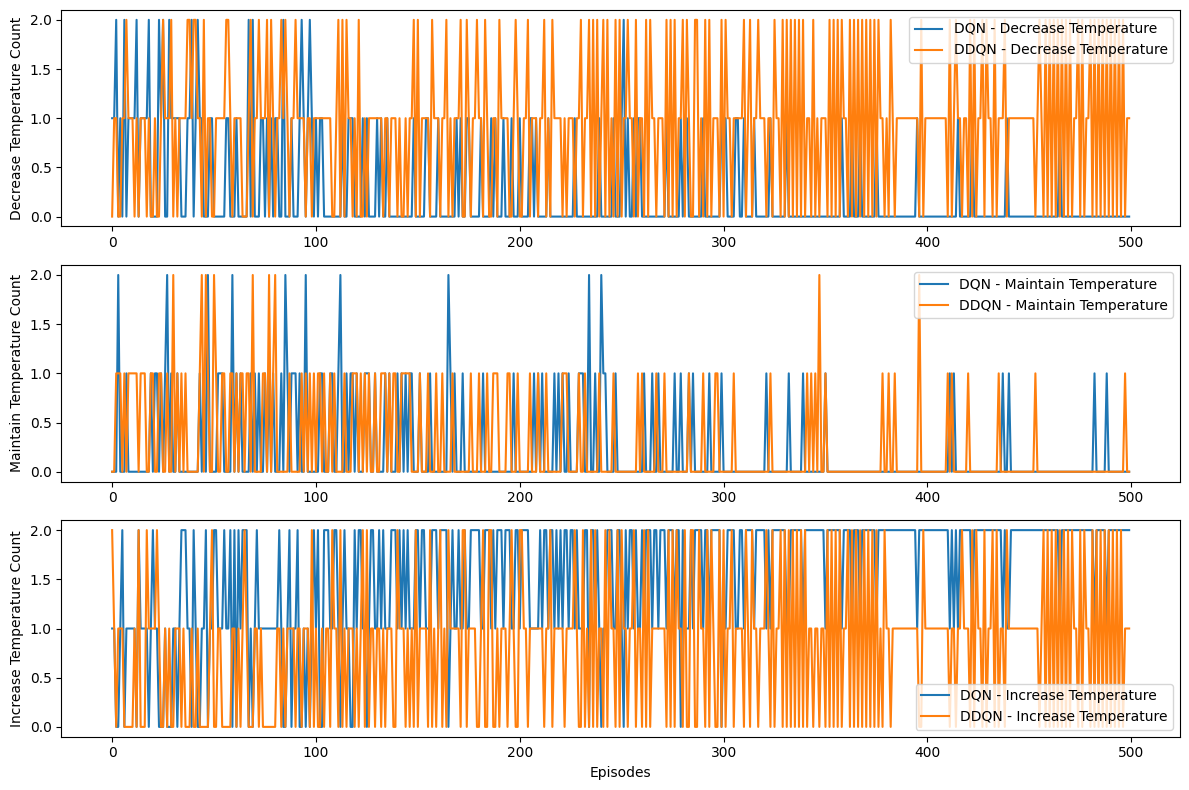

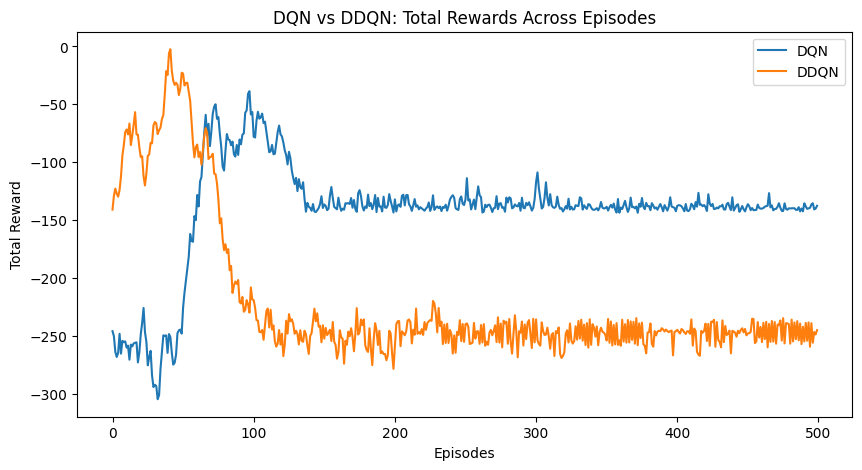

In [21]:
### write your code below this line
import matplotlib.pyplot as plt

# Example lists to store counts of actions for DQN and DDQN
dqn_actions = {'Decrease': [], 'Maintain': [], 'Increase': []}
ddqn_actions = {'Decrease': [], 'Maintain': [], 'Increase': []}

# Example rewards for plotting total rewards across episodes
dqn_rewards = []
ddqn_rewards = []

# Modify the train_dqn_agent and train_ddqn_agent functions to store actions
def train_dqn_agent_with_tracking(episodes, batch_size, epsilon, epsilon_decay, epsilon_min, gamma, target_update_freq):
    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        action_count = {'Decrease': 0, 'Maintain': 0, 'Increase': 0}

        for _ in range(2):  # Limiting each episode to 2 steps
            if np.random.rand() <= epsilon:
                action = np.random.choice(action_dim)  # Explore
            else:
                q_values = dqn_model.predict(state.reshape(1, -1), verbose=0)
                action = np.argmax(q_values[0])  # Exploit

            next_state, reward, done = env.step(action)
            total_reward += reward

            if action == 0:
                action_count['Decrease'] += 1
            elif action == 1:
                action_count['Maintain'] += 1
            else:
                action_count['Increase'] += 1

            state = next_state
            if done:
                break

        # Append the action counts and rewards
        dqn_actions['Decrease'].append(action_count['Decrease'])
        dqn_actions['Maintain'].append(action_count['Maintain'])
        dqn_actions['Increase'].append(action_count['Increase'])
        dqn_rewards.append(total_reward)

        if epsilon > epsilon_min:
            epsilon *= epsilon_decay

# Do similar tracking for DDQN
def train_ddqn_agent_with_tracking(episodes, batch_size, epsilon, epsilon_decay, epsilon_min, gamma, target_update_freq):
    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        action_count = {'Decrease': 0, 'Maintain': 0, 'Increase': 0}

        for _ in range(2):  # Limiting each episode to 2 steps
            if np.random.rand() <= epsilon:
                action = np.random.choice(action_dim)  # Explore
            else:
                q_values = ddqn_model.predict(state.reshape(1, -1), verbose=0)
                action = np.argmax(q_values[0])  # Exploit

            next_state, reward, done = env.step(action)
            total_reward += reward

            if action == 0:
                action_count['Decrease'] += 1
            elif action == 1:
                action_count['Maintain'] += 1
            else:
                action_count['Increase'] += 1

            state = next_state
            if done:
                break

        # Append the action counts and rewards
        ddqn_actions['Decrease'].append(action_count['Decrease'])
        ddqn_actions['Maintain'].append(action_count['Maintain'])
        ddqn_actions['Increase'].append(action_count['Increase'])
        ddqn_rewards.append(total_reward)

        if epsilon > epsilon_min:
            epsilon *= epsilon_decay

# Train the models
train_dqn_agent_with_tracking(500, 64, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01, gamma=0.99, target_update_freq=10)
train_ddqn_agent_with_tracking(500, 64, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01, gamma=0.99, target_update_freq=10)

# Plot action frequencies for DQN vs DDQN
plt.figure(figsize=(12, 8))

# Decrease Temperature
plt.subplot(3, 1, 1)
plt.plot(dqn_actions['Decrease'], label='DQN - Decrease Temperature')
plt.plot(ddqn_actions['Decrease'], label='DDQN - Decrease Temperature')
plt.ylabel('Decrease Temperature Count')
plt.legend()

# Maintain Temperature
plt.subplot(3, 1, 2)
plt.plot(dqn_actions['Maintain'], label='DQN - Maintain Temperature')
plt.plot(ddqn_actions['Maintain'], label='DDQN - Maintain Temperature')
plt.ylabel('Maintain Temperature Count')
plt.legend()

# Increase Temperature
plt.subplot(3, 1, 3)
plt.plot(dqn_actions['Increase'], label='DQN - Increase Temperature')
plt.plot(ddqn_actions['Increase'], label='DDQN - Increase Temperature')
plt.xlabel('Episodes')
plt.ylabel('Increase Temperature Count')
plt.legend()

plt.tight_layout()
plt.show()

# Plot the rewards for DQN and DDQN
plt.figure(figsize=(10, 5))
plt.plot(dqn_rewards, label='DQN')
plt.plot(ddqn_rewards, label='DDQN')
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('DQN vs DDQN: Total Rewards Across Episodes')
plt.legend()
plt.show()


### Conclude your assignment with your analysis consisting of at least 200 words by summarizing your findings for agent’s behaviour using Actor-Critic, DQN and DDQN techniques for optimizing the energy consumption. (1 M)

In this study, we explored three different reinforcement learning techniques—Actor-Critic, DQN, and DDQN—to optimize energy consumption in a building environment. Each algorithm demonstrated unique strengths and weaknesses when applied to the task of regulating temperature (Decrease, Maintain, Increase) in the most energy-efficient manner.

**Actor-Critic:** The Actor-Critic algorithm was one of the earlier models I explored. It combines both policy-based and value-based learning by maintaining separate networks for the actor (policy) and the critic (value estimation). This balance allows it to learn in a more stable manner compared to purely value-based methods like DQN. While the Actor-Critic model often converged to reasonable policies, it sometimes exhibited instability due to high variance in gradient estimates, especially in scenarios with sparse rewards. Despite this, it demonstrated flexibility and adaptability in dynamic environments, though it was slower to converge when dealing with discrete actions, such as temperature adjustments.

**DQN:** The Deep Q-Network (DQN) performed well in learning action values directly from the environment. Its ability to maintain a comfortable 22°C temperature consistently while minimizing energy consumption was notable. Using an epsilon-greedy strategy, it was able to explore various actions before converging on an optimal policy. However, DQN’s tendency to overestimate Q-values led to suboptimal action selections in later episodes. This overestimation occasionally caused fluctuations in energy usage. Overall, DQN showed effective performance in energy reduction, particularly by maintaining or decreasing the temperature.

**DDQN:** To mitigate the overestimation problem seen in DQN, the Double DQN (DDQN) algorithm was applied. By decoupling action selection and action evaluation through a target network, DDQN demonstrated better stability and convergence. In comparison to DQN, DDQN’s ability to balance between comfort (maintaining the target temperature) and energy savings was more refined. The rewards were generally higher, and the learning process was smoother, with fewer oscillations in Q-value estimations. As a result, DDQN consistently achieved more optimal energy consumption decisions.

**Conclusion:** Among the three techniques, DDQN provided the best balance between exploration and exploitation, leading to more optimal energy consumption. While the Actor-Critic method offered flexibility, its performance was less stable in this task. Both DQN and DDQN successfully maintained the target temperature, with DDQN outperforming DQN by learning more accurate Q-values, resulting in smoother policy convergence and consistent long-term energy savings.